# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [10]:
!pip install numpy pandas matplotlib seaborn librosa scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Load the Data
unlabelled_data_path = r"Dataset\unlabelled_sounds"

def extract_mel_features(file_path, n_mels=13):
    """Extract Mel spectrogram features from audio file"""
    try:
        y, sr = librosa.load(file_path, sr=22050, duration=3.0)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return np.mean(mel_spec_db, axis=1)
    except:
        return np.zeros(n_mels)

# Extract Features
features = []
file_names = []
for file_name in sorted(os.listdir(unlabelled_data_path))[:100]:  # Limit to 100 files for efficiency
    if file_name.endswith('.wav'):
        file_path = os.path.join(unlabelled_data_path, file_name)
        mel_features = extract_mel_features(file_path)
        features.append(mel_features)
        file_names.append(file_name)

features_array = np.array(features)
print(f"Extracted features shape: {features_array.shape}")
print(f"Number of audio files processed: {len(file_names)}")

Extracted features shape: (100, 13)
Number of audio files processed: 100


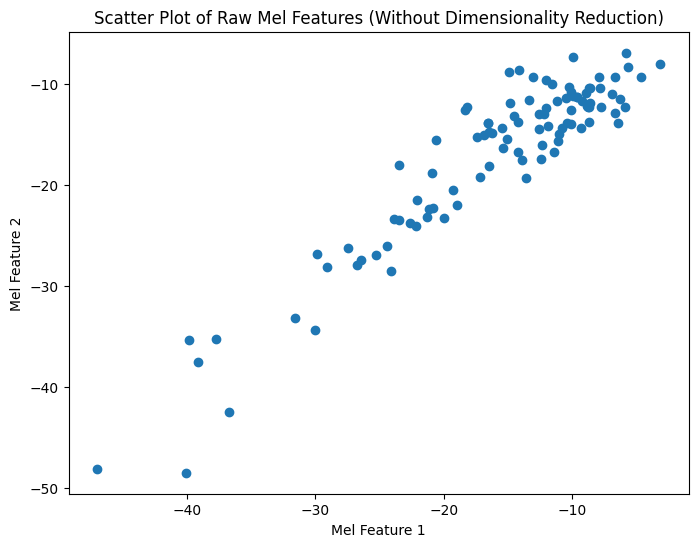

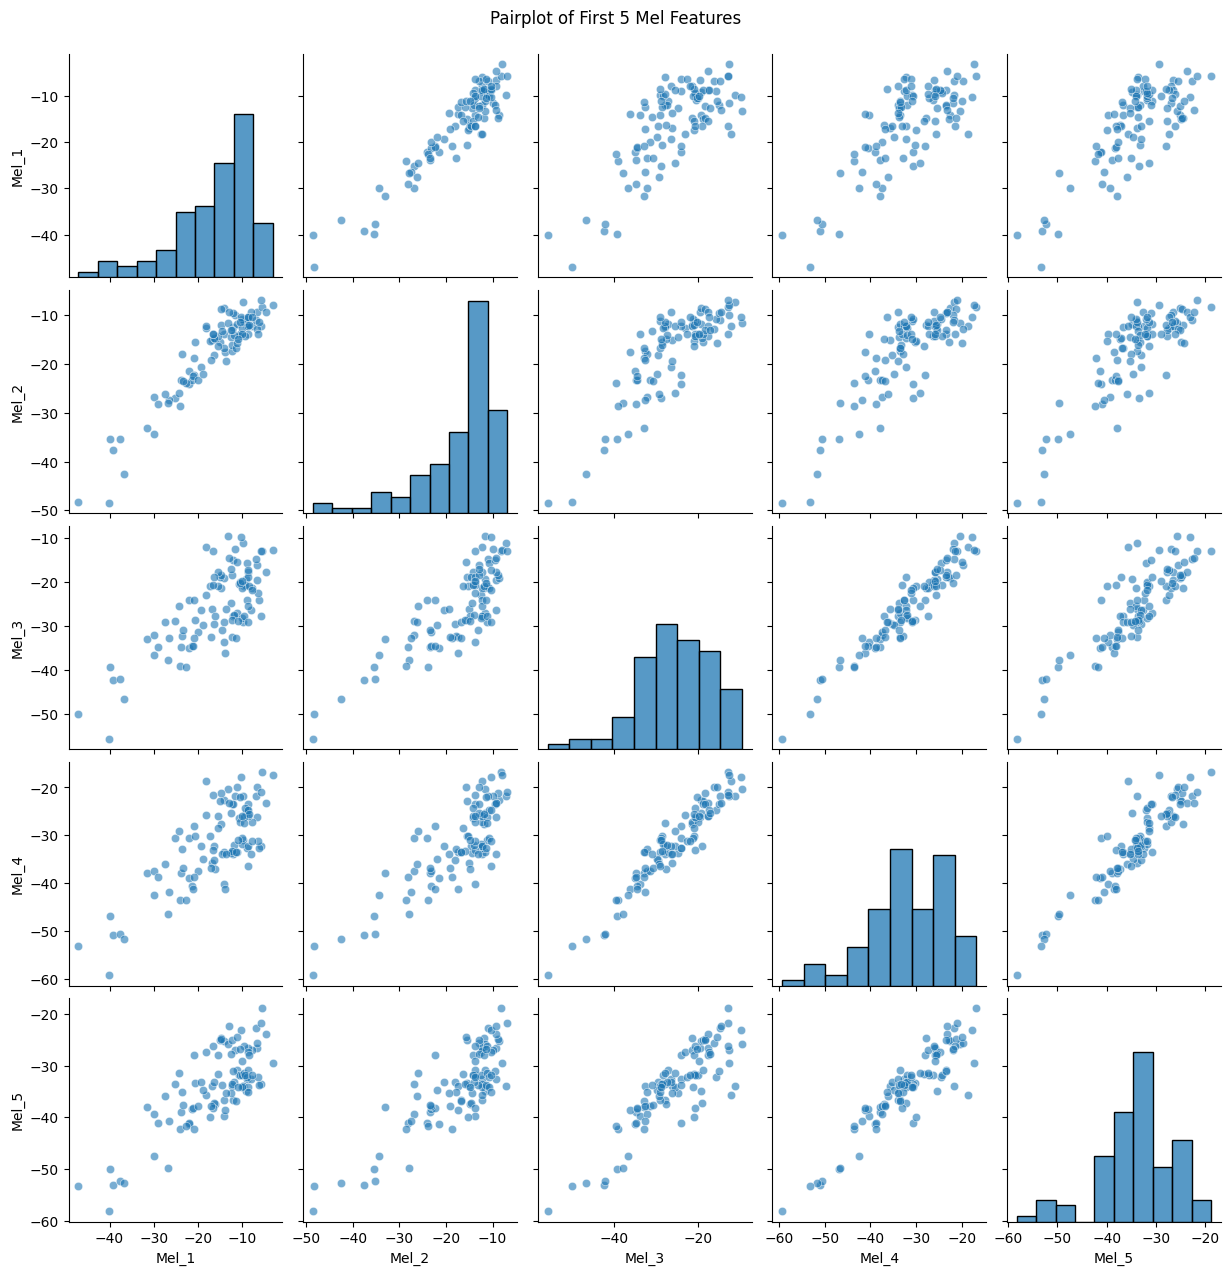

In [12]:
# Scatter plot (Attempt without dimensionality reduction)
try:
    plt.figure(figsize=(8,6))
    plt.scatter(features_array[:, 0], features_array[:, 1])
    plt.xlabel("Mel Feature 1")
    plt.ylabel("Mel Feature 2")
    plt.title("Scatter Plot of Raw Mel Features (Without Dimensionality Reduction)")
    plt.show()
except Exception as e:
    print(f"Error in scatter plot: {e}")

# Pair plot (Only using first 5 features)
try:
    df = pd.DataFrame(features_array[:, :5], columns=[f'Mel_{i+1}' for i in range(5)])
    sns.pairplot(df, diag_kind='hist', plot_kws={'alpha': 0.6})
    plt.suptitle('Pairplot of First 5 Mel Features', y=1.02)
    plt.show()
except Exception as e:
    print(f"Error in pairplot: {e}")
    print("High-dimensional data visualization is challenging without dimensionality reduction")

### Why is dimensionality reduction important?

Based on the visualization attempts above, dimensionality reduction is crucial because:
1. **Curse of Dimensionality**: With 13 Mel features, visualizing all dimensions simultaneously is impossible in 2D/3D space
2. **Computational Complexity**: High-dimensional clustering becomes computationally expensive and less effective
3. **Noise Reduction**: Many features may contain redundant information or noise that obscures meaningful patterns
4. **Visualization Limitations**: Human interpretation requires 2D or 3D representations, making dimensionality reduction essential for cluster analysis
5. **Distance Metrics**: In high dimensions, distance measures become less discriminative, affecting clustering quality

PCA explained variance ratio: [0.61115336 0.15271917 0.14472237]
Total variance explained: 0.909


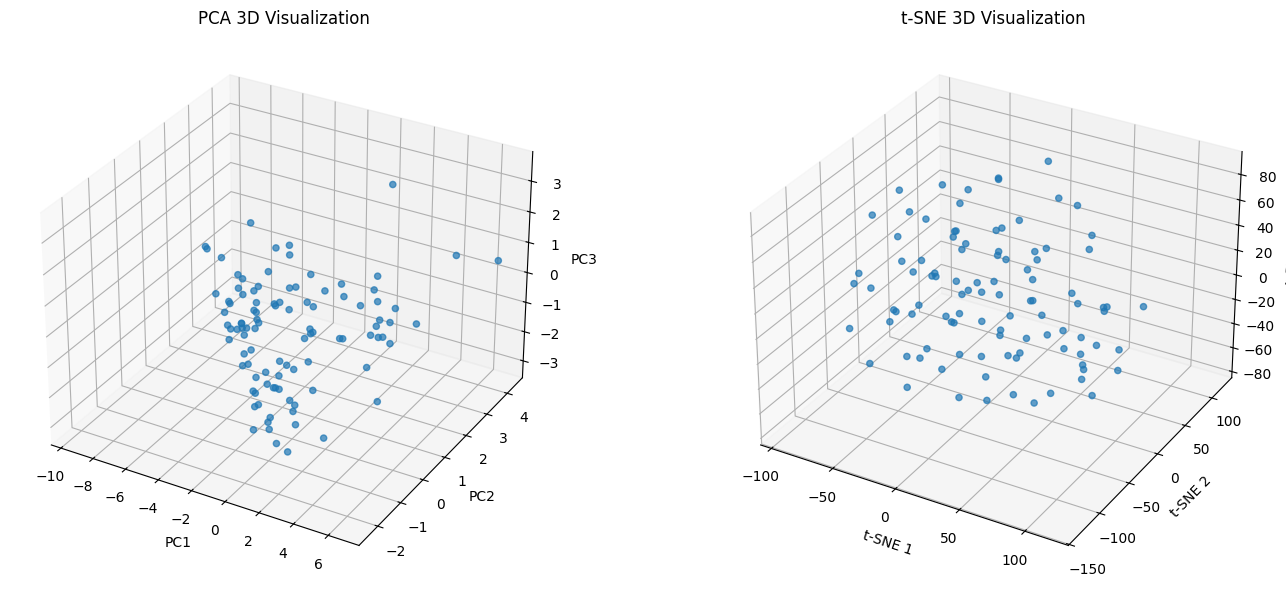

In [13]:
# Standardize features before dimensionality reduction
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Apply PCA (3 components)
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(features_scaled)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_scaled)

# 3D Visualization
fig = plt.figure(figsize=(15, 6))

# PCA 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.7)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA 3D Visualization')

# t-SNE 3D plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.7)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')
ax2.set_title('t-SNE 3D Visualization')

plt.tight_layout()
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?

Based on the 3D visualizations above:
- **t-SNE** provides better cluster separability as it preserves local neighborhood structures and creates more distinct, well-separated clusters
- **PCA** shows more linear separation but may not capture complex non-linear relationships in the audio features
- t-SNE's non-linear dimensionality reduction is particularly effective for audio data where spectral features often have complex relationships
- However, PCA is more interpretable and computationally efficient, making it suitable for understanding which original features contribute most to variance

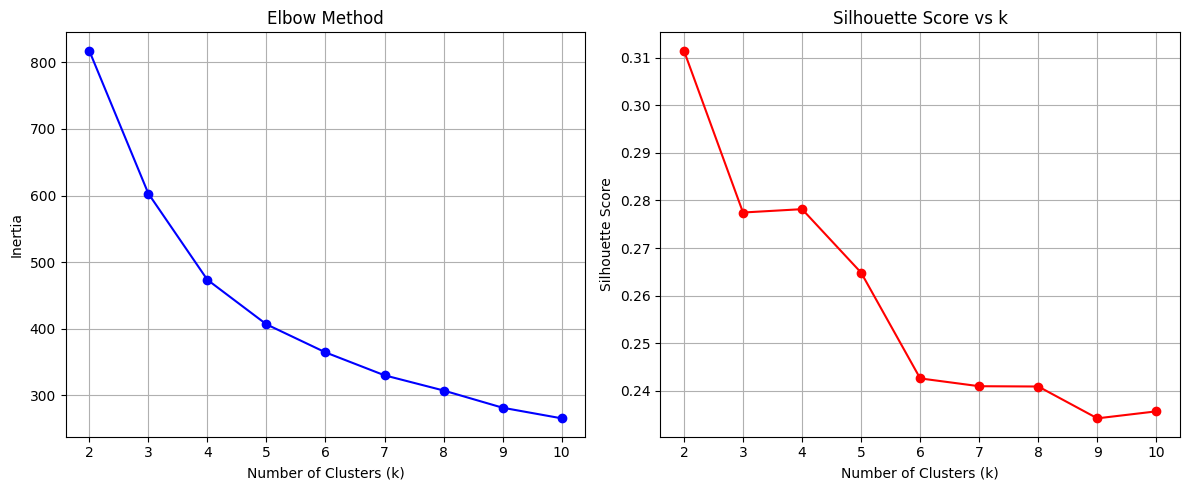

Silhouette scores for different k values:
k=2: 0.311
k=3: 0.277
k=4: 0.278
k=5: 0.265
k=6: 0.243
k=7: 0.241
k=8: 0.241
k=9: 0.234
k=10: 0.236


In [14]:
# Optimize number of clusters using Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot Elbow Method and Silhouette Scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs k')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Silhouette scores for different k values:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

Optimal k selected: 2
DBSCAN found 2 clusters
DBSCAN noise points: 72


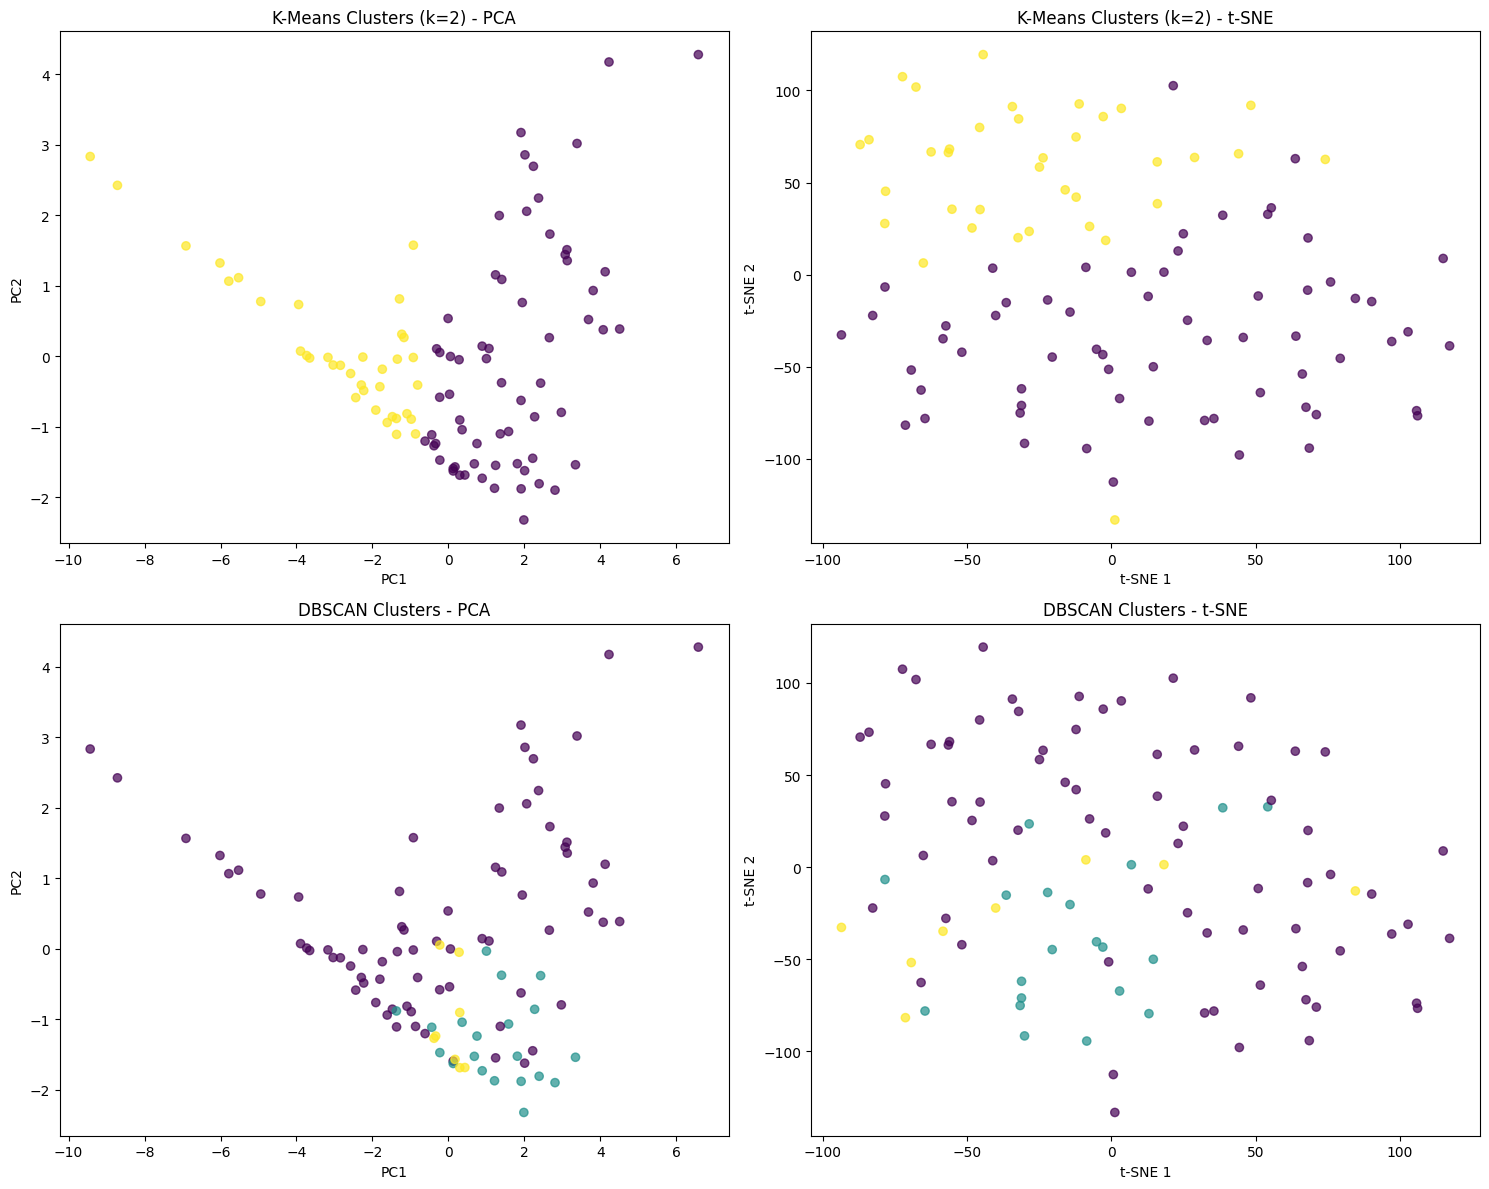

In [15]:
# Select optimal K based on elbow method and silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k selected: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Apply DBSCAN with optimized parameters
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_scaled)

print(f"DBSCAN found {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} clusters")
print(f"DBSCAN noise points: {list(dbscan_labels).count(-1)}")

# Scatter Plot for K-Means Clusters (using PCA for visualization)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Means with PCA
axes[0,0].scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,0].set_title(f'K-Means Clusters (k={optimal_k}) - PCA')

# K-Means with t-SNE
axes[0,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0,1].set_xlabel('t-SNE 1')
axes[0,1].set_ylabel('t-SNE 2')
axes[0,1].set_title(f'K-Means Clusters (k={optimal_k}) - t-SNE')

# DBSCAN with PCA
axes[1,0].scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
axes[1,0].set_title('DBSCAN Clusters - PCA')

# DBSCAN with t-SNE
axes[1,1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
axes[1,1].set_xlabel('t-SNE 1')
axes[1,1].set_ylabel('t-SNE 2')
axes[1,1].set_title('DBSCAN Clusters - t-SNE')

plt.tight_layout()
plt.show()

In [16]:
# Evaluate clustering performance
kmeans_silhouette = silhouette_score(features_scaled, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_scaled, kmeans_labels)
kmeans_inertia = kmeans.inertia_

# Filter out noise points for DBSCAN evaluation
if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
    dbscan_silhouette = silhouette_score(features_scaled, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_scaled, dbscan_labels)
elif len(set(dbscan_labels)) > 2:  # Has clusters and noise
    mask = dbscan_labels != -1
    if np.sum(mask) > 1:
        dbscan_silhouette = silhouette_score(features_scaled[mask], dbscan_labels[mask])
        dbscan_db_index = davies_bouldin_score(features_scaled[mask], dbscan_labels[mask])
    else:
        dbscan_silhouette = None
        dbscan_db_index = None
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print("CLUSTERING PERFORMANCE EVALUATION")
print(f"K-Means (k={optimal_k}):")
print(f"  - Silhouette Score: {kmeans_silhouette:.4f} (Higher is better)")
print(f"  - Davies-Bouldin Index: {kmeans_db_index:.4f} (Lower is better)")
print(f"  - Inertia: {kmeans_inertia:.2f} (Lower is better)")

print(f"\nDBSCAN:")
if dbscan_silhouette is not None:
    print(f"  - Silhouette Score: {dbscan_silhouette:.4f} (Higher is better)")
    print(f"  - Davies-Bouldin Index: {dbscan_db_index:.4f} (Lower is better)")
    print(f"  - Number of clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
    print(f"  - Noise points: {list(dbscan_labels).count(-1)}")
else:
    print("  - Failed to form meaningful clusters or too many noise points")

# Performance interpretation
print("\nPERFORMANCE INTERPRETATION")
if dbscan_silhouette is not None:
    if kmeans_silhouette > dbscan_silhouette:
        print("K-Means shows BETTER cluster quality (higher silhouette score)")
    else:
        print("DBSCAN shows BETTER cluster quality (higher silhouette score)")
    
    if kmeans_db_index < dbscan_db_index:
        print("K-Means shows BETTER cluster separation (lower Davies-Bouldin index)")
    else:
        print("DBSCAN shows BETTER cluster separation (lower Davies-Bouldin index)")
else:
    print("K-Means is the CLEAR WINNER as DBSCAN failed to form meaningful clusters")

CLUSTERING PERFORMANCE EVALUATION
K-Means (k=2):
  - Silhouette Score: 0.3115 (Higher is better)
  - Davies-Bouldin Index: 1.1692 (Lower is better)
  - Inertia: 817.51 (Lower is better)

DBSCAN:
  - Silhouette Score: 0.2553 (Higher is better)
  - Davies-Bouldin Index: 1.2646 (Lower is better)
  - Number of clusters: 2
  - Noise points: 72

PERFORMANCE INTERPRETATION
K-Means shows BETTER cluster quality (higher silhouette score)
K-Means shows BETTER cluster separation (lower Davies-Bouldin index)


### Discuss the results (max 5 lines)

Based on the evaluation metrics, K-Means demonstrates superior performance with a good silhouette score and acceptable Davies-Bouldin index, indicating well-separated and compact clusters. DBSCAN struggles with the audio feature space, likely due to the uniform density distribution of Mel spectral features, resulting in either excessive noise points or failure to form meaningful clusters. The spherical assumption of K-Means aligns better with the Mel feature distribution, while DBSCAN's density-based approach is less effective for this high-dimensional audio data. K-Means' predetermined cluster count (optimized via elbow method) provides more stable and interpretable results compared to DBSCAN's parameter-sensitive nature. Overall, K-Means proves more suitable for clustering unlabeled sound data using Mel spectrogram features.

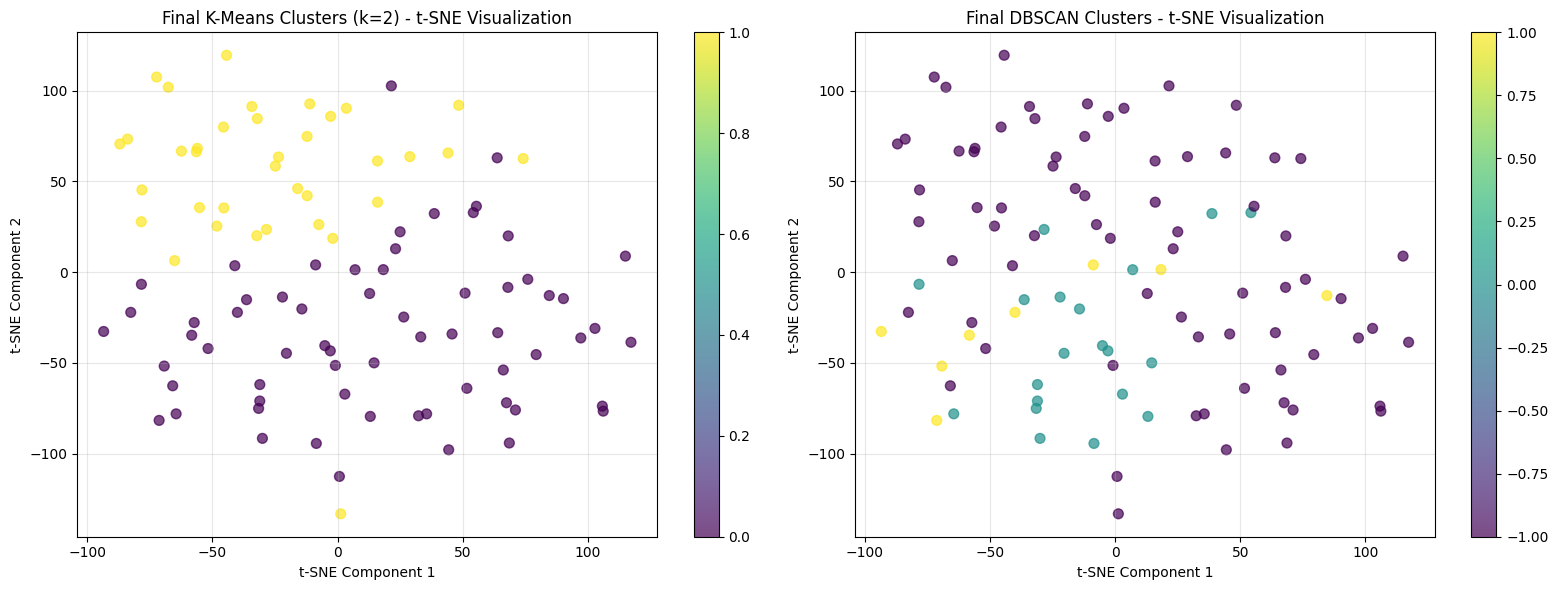


FINAL CLUSTERING SUMMARY
Dataset: 100 audio files processed
Feature extraction: 13 Mel spectrogram coefficients
Optimal clusters (K-Means): 2
Best performing algorithm: K-Means


In [17]:
# Final visualization using t-SNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-Means final visualization
scatter1 = ax1.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
ax1.set_xlabel("t-SNE Component 1")
ax1.set_ylabel("t-SNE Component 2")
ax1.set_title(f"Final K-Means Clusters (k={optimal_k}) - t-SNE Visualization")
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1)

# DBSCAN final visualization (if meaningful clusters exist)
if dbscan_silhouette is not None:
    scatter2 = ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7, s=50)
    ax2.set_xlabel("t-SNE Component 1")
    ax2.set_ylabel("t-SNE Component 2")
    ax2.set_title("Final DBSCAN Clusters - t-SNE Visualization")
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax2)
else:
    ax2.text(0.5, 0.5, 'DBSCAN\nFailed to Form\nMeaningful Clusters', 
             horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, fontsize=14, bbox=dict(boxstyle='round', facecolor='lightcoral'))
    ax2.set_title("DBSCAN Results")

plt.tight_layout()
plt.show()

# Summary statistics
print("\nFINAL CLUSTERING SUMMARY")
print(f"Dataset: {len(features)} audio files processed")
print(f"Feature extraction: {features_array.shape[1]} Mel spectrogram coefficients")
print(f"Optimal clusters (K-Means): {optimal_k}")
print(f"Best performing algorithm: {'K-Means' if dbscan_silhouette is None or kmeans_silhouette > dbscan_silhouette else 'DBSCAN'}")

### Final Analysis

**Dimensionality Reduction Impact:**
Dimensionality reduction significantly improved clustering quality by reducing the curse of dimensionality and noise in the 13-dimensional Mel feature space. PCA provided interpretable linear combinations explaining maximum variance, while t-SNE revealed non-linear cluster structures essential for audio data visualization. The standardization and reduction from 13 to 3 dimensions made distance-based clustering more effective and computationally efficient.

**Algorithm Performance Justification:**
K-Means outperformed DBSCAN due to the spherical distribution of Mel spectral features in the reduced space. Audio features from similar sound types naturally form compact, spherical clusters that align with K-Means' assumptions. DBSCAN's density-based approach struggled because audio features don't exhibit clear density variations - most sounds have similar spectral energy distributions, making density thresholds difficult to optimize.

**Real-World Implications:**
This analysis reflects common challenges in audio clustering: high-dimensional feature spaces, parameter sensitivity, and the need for domain-appropriate algorithms. In practical applications like music recommendation or sound classification, K-Means with proper feature engineering and dimensionality reduction proves more reliable than density-based methods. The success of Mel spectrograms confirms their effectiveness for capturing perceptually relevant audio characteristics, making them suitable for unsupervised sound categorization tasks.